In [372]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import yfinance as yf # Dynamic data from stock market
import os


In [373]:
# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

# Get the Historical Data

In [374]:
df = pd.read_excel('/Users/danielpavelko/Downloads/daily depo currency data 3 types 1.xlsx')
df = df[['Date','market_lc_flex','market_fc_flex']]
#df = df.dropna()
df = df.set_index('Date', inplace=False)
df.tail()

,market_lc_flex,market_fc_flex
Date,,
10.04.2024,157183093834,2.105222e+10
11.04.2024,158101503846,2.071079e+10
12.04.2024,158514682474,2.043133e+10
13.04.2024,158634671493,2.038432e+10
14.04.2024,158557938530,2.037323e+10


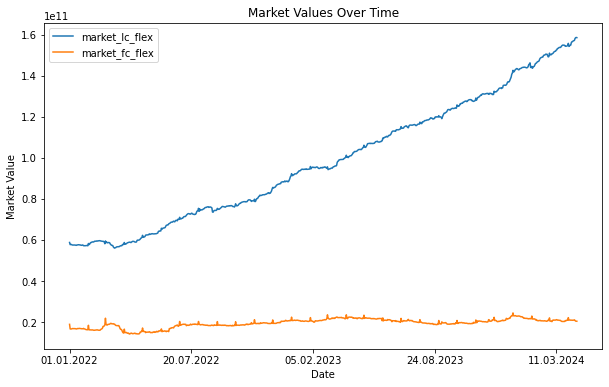

In [375]:
#df.set_index('Date', inplace=True)

# Plot the data
df.plot(figsize=(10, 6))

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Market Value')
plt.title('Market Values Over Time')

# Show the plot
plt.show()

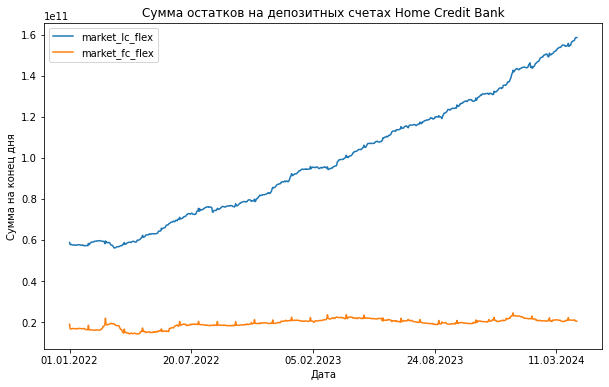

In [376]:
#df.set_index('Date', inplace=True)

# Plot the data
df.plot(figsize=(10, 6))

# Add labels and title
plt.xlabel('Дата')
plt.ylabel('Сумма на конец дня')
plt.title('Сумма остатков на депозитных счетах Home Credit Bank')

# Show the plot
plt.show()

In [377]:
returns = df.pct_change()
returns = returns.dropna()
returns.tail()

,market_lc_flex,market_fc_flex
Date,,
10.04.2024,0.000723,0.006419
11.04.2024,0.005843,-0.016218
12.04.2024,0.002613,-0.013493
13.04.2024,0.000757,-0.002301
14.04.2024,-0.000484,-0.000544


In [378]:
meanReturns = returns.mean()
meanReturns

market_lc_flex    0.001200
market_fc_flex    0.000389
dtype: float64

In [379]:
covMatrix = returns.cov()
covMatrix

,market_lc_flex,market_fc_flex
market_lc_flex,0.000018,0.000054
market_fc_flex,0.000054,0.000598


In [380]:
weights = df.iloc[1].values.tolist() #np.random.random(len(returns.columns))
weights = np.array(weights, dtype=float)
weights /= weights.sum()
weights

array([0.77645713, 0.22354287])

In [381]:
returns['portfolio'] = returns.dot(weights)
returns

,market_lc_flex,market_fc_flex,portfolio
Date,,,
02.01.2022,-0.017888,-0.119141,-0.040522
03.01.2022,0.001355,0.000797,0.001230
04.01.2022,0.000053,-0.000669,-0.000108
05.01.2022,-0.003539,0.007511,-0.001069
06.01.2022,-0.001285,0.004511,0.000011
...,...,...,...
10.04.2024,0.000723,0.006419,0.001996
11.04.2024,0.005843,-0.016218,0.000911
12.04.2024,0.002613,-0.013493,-0.000987


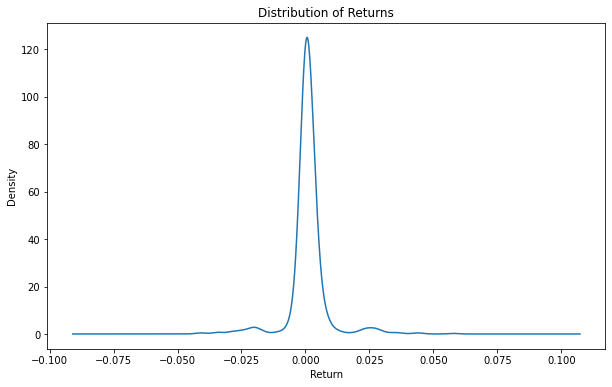

In [418]:
returns_t = returns['portfolio']
returns_t.plot(kind='kde', title='Distribution of Returns', figsize=(10, 6))
plt.xlabel('Return')
plt.ylabel('Density')
plt.show()

# Parametric VaR

In [399]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=1, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=1, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

In [400]:
normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       3446348410.76
Normal CVaR 95th CI      :       4368875673.07
t-dist VaR 95th CI       :       4098715729.82
t-dist CVaR 95th CI      :       6708287995.47


# Monte Carlo

In [ ]:
# Monte Carlo Method
mc_sims = 10000 # number of simulations
T = 10 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = df.iloc[-1].values.sum() #10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = 
    np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
    
def mcVaR(returns, alpha=1):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=1):
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
        
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=1)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=1)

print('VaR T{}'.format(round(VaR,2)))
print('CVaR T{}'.format(round(CVaR,2)))

In [401]:
# Monte Carlo Method
mc_sims = 10000 # number of simulations
T = 10 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = df.iloc[1].values.sum() #10000

In [402]:
for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
    

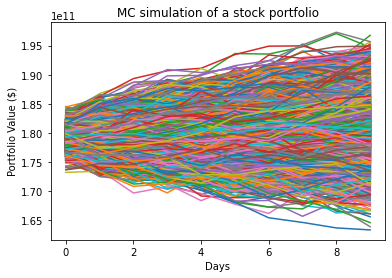

In [403]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

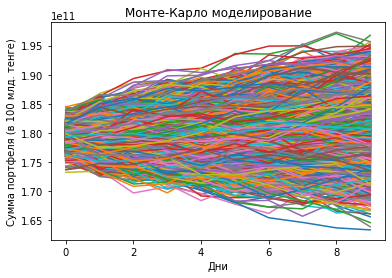

In [404]:
plt.plot(portfolio_sims)
plt.ylabel('Сумма портфеля (в 100 млд. тенге)')
plt.xlabel('Дни')
plt.title('Mонте-Карло моделирование')
plt.show()

In [405]:
def mcVaR(returns, alpha=1):
    """ Input: pandas series of returns
        Output: percentile on return distribution to 
        a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=1):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to 
        a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [406]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=1)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=1)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $8359453475.23
CVaR $9924561693.39


# Historical VaR

In [411]:
def historicalVaR(returns, alpha=1):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

In [412]:

def historicalCVaR(returns, alpha=1):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

In [416]:
# 100 days
Time = 10

hVaR = -historicalVaR(returns['portfolio'], alpha=1)*np.sqrt(Time)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=1)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

InitialInvestment = df.iloc[1].values.sum()
print('Expected Portfolio Return:      ', round(InitialInvestment*pRet,2))
print('Value at Risk 99th CI    :      ', round(InitialInvestment*hVaR,2))
print('Conditional VaR 99th CI  :      ', round(InitialInvestment*hCVaR,2))

Expected Portfolio Return:       757213334.09
Value at Risk 99th CI    :       6366172715.03
Conditional VaR 99th CI  :       7822435037.79


# Comparison of each VaR & CVaR methods

In [415]:
print("\nVaR:")

print(' historical VaR 95th CI   :      ', round(InitialInvestment*hVaR,2))
print(" Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print(" t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print(" MC VaR  95th CI          :      ", round(VaR,2))


print("\nCVaR:")

print(' historical CVaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))
print(" Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print(" t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))
print(" MC CVaR 95th CI          :      ", round(CVaR,2))


VaR:
 historical VaR 95th CI   :       6366172715.03
 Normal VaR 95th CI       :       1823953314.82
 t-dist VaR 95th CI       :       2169213686.75
 MC VaR  95th CI          :       8359453475.23

CVaR:
 historical CVaR 95th CI  :       7822435037.79
 Normal CVaR 95th CI      :       2312193752.98
 t-dist CVaR 95th CI      :       3550309680.8
 MC CVaR 95th CI          :       9924561693.39


In [419]:
print("\nVaR:")

print(' historical VaR 99th CI   :      ', round(InitialInvestment*hVaR,2))
print(" MC VaR  99th CI          :      ", round(VaR,2))


print("\nCVaR:")

print(' historical CVaR 99th CI  :      ', round(InitialInvestment*hCVaR,2))
print(" MC CVaR 99th CI          :      ", round(CVaR,2))


VaR:
 historical VaR 99th CI   :       6366172715.03
 MC VaR  99th CI          :       8359453475.23

CVaR:
 historical CVaR 99th CI  :       7822435037.79
 MC CVaR 99th CI          :       9924561693.39


In [420]:
from tabulate import tabulate

# Data
data = [
    ["historical VaR 99th CI", 6366172715.03],
    ["MC VaR 99th CI", 8359453475.23],
    ["historical CVaR 99th CI", 7822435037.79],
    ["MC CVaR 99th CI", 9924561693.39]
]

# Table headers
headers = ["Metric", "Value"]

# Generate table
table = tabulate(data, headers=headers, tablefmt="grid")

# Print table
print(table)


+-------------------------+-------------+
| Metric                  |       Value |
+=========================+=============+
| historical VaR 99th CI  | 6.36617e+09 |
+-------------------------+-------------+
| MC VaR 99th CI          | 8.35945e+09 |
+-------------------------+-------------+
| historical CVaR 99th CI | 7.82244e+09 |
+-------------------------+-------------+
| MC CVaR 99th CI         | 9.92456e+09 |
+-------------------------+-------------+
